This is a companion notebook for the book [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff). For readability, it only contains runnable code blocks and section titles, and omits everything else in the book: text paragraphs, figures, and pseudocode.

**If you want to be able to follow what's going on, I recommend reading the notebook side by side with your copy of the book.**

This notebook was generated for TensorFlow 2.6.

# Introduction to deep learning for computer vision

Computer vision is the problem domain that led to the initial rise of deep learning between 2011 and 2015. A type of deep learning called convolutional neural networks started getting remarkably good results on image classification competitions around that time, first with Dan Ciresan winning two niche competitions (the ICDAR 2011 Chinese character recognition competition and the IJCNN 2011 German traffic signs recognition competition), then more notably in Fall 2012 with Hinton’s group winning the high-profile ImageNet large-scale visual recognition challenge.

## Introduction to convnets

We’re about to dive into the theory of what convnets are and why they have been so successful at computer vision tasks. But first, let’s take a practical look at a simple convnet example. It uses a convnet to classify MNIST digits, a task we performed in chapter 2 using a densely-connected network (our test accuracy then was 97.8%). Even though the convnet will be basic, its accuracy will blow out of the water that of the densely connected model from chapter 2.

### Instantiating a small convnet

The following lines of code show you what a basic convnet looks like. It’s a stack of `Conv2D` and `MaxPooling2D` layers. You’ll see in a minute exactly what they do. We’ll build the model using the `Functional API`, which we introduced in the previous chapter.

In [1]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(28, 28, 1))  # (image_height, image_width, image_channels)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(10, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

### Displaying the model's summary

In [2]:
# Let’s display the architecture of our convnet
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 128)         73856     
_________________________________________________________________
flatten (Flatten)            (None, 1152)              0     

You can see that the output of every `Conv2D` and `MaxPooling2D` layer is a 3D tensor of shape (height, width, channels). The width and height dimensions tend to **shrink** as you go deeper in the model. The number of channels is controlled by the first argument passed to the `Conv2D` layers (32, 64, or 128).

### Training the convnet on MNIST images

Now, let’s train the convnet on the MNIST digits. We’ll reuse a lot of the code from the MNIST example in chapter 2. Because we’re doing 10-ways classification with a softmax output, we’ll use the **categorical crossentropy loss**, and because our labels are integers, we’ll use the sparse version, ***sparse_categorical_crossentropy**.

In [3]:
from tensorflow.keras.datasets import mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype("float32") / 255
test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype("float32") / 255

model.compile(optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])

history = model.fit(train_images, train_labels, epochs=5, batch_size=64)

11501568/11490434 [==============================] - 0s 0us/step
Epoch 1/5
938/938 [==============================] - 35s 4ms/step - loss: 0.1556 - accuracy: 0.9520
Epoch 2/5
938/938 [==============================] - 3s 3ms/step - loss: 0.0441 - accuracy: 0.9866
Epoch 3/5
938/938 [==============================] - 3s 3ms/step - loss: 0.0306 - accuracy: 0.9906
Epoch 4/5
938/938 [==============================] - 3s 3ms/step - loss: 0.0226 - accuracy: 0.9927
Epoch 5/5
938/938 [==============================] - 3s 3ms/step - loss: 0.0177 - accuracy: 0.9945


### Evaluating the convnet

In [4]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f"Test accuracy: {test_acc:.3f}")

313/313 [==============================] - 1s 2ms/step - loss: 0.0286 - accuracy: 0.9915
Test accuracy: 0.992


Whereas the densely-connected model from chapter 2 had a test accuracy of $97.8\%$, the basic convnet has a test accuracy of $99.1\%$: we decreased the error rate by about $60\%$ (relative). Not bad!

### The convolution operation

The fundamental difference between a densely-connected layer and a convolution layer is this: `Dense` layers learn **global patterns** in their input feature space (for example, for a MNIST digit, patterns involving all pixels), whereas convolution layers learn **local patterns** (see figure): in the case of images, patterns found in small 2D windows of the inputs. In the previous example, these windows were all $3 \times 3$.

![](https://drek4537l1klr.cloudfront.net/chollet2/v-7/Figures/local_patterns.jpg)

This key characteristic gives convnets two interesting properties:

- The patterns they learn are **translation invariant**. After learning a certain pattern in the lower-right corner of a picture, a convnet can recognize it anywhere: for example, in the upper-left corner. A densely-connected model would have to learn the pattern anew if it appeared at a new location. This makes convnets data efficient when processing images (because the visual world is fundamentally translation invariant): they need fewer training samples to learn representations that have generalization power.
- They can learn **spatial hierarchies of patterns** (see figure). A first convolution layer will learn small local patterns such as edges, a second convolution layer will learn larger patterns made of the features of the first layers, and so on. This allows convnets to efficiently learn increasingly complex and abstract visual concepts—because the visual world is fundamentally spatially hierarchical.

![](https://drek4537l1klr.cloudfront.net/chollet2/v-7/Figures/visual_hierarchy_hires.png)

Convolutions operate over 3D tensors, called **feature maps**, with two spatial axes (height and width) as well as a depth axis (also called the channels axis). For an RGB image, the dimension of the depth axis is 3, because the image has three color channels: red, green, and blue. For a black-and-white picture, like the MNIST digits, the depth is 1 (levels of gray). The convolution operation extracts patches from its input feature map and applies the same transformation to all of these patches, producing an output feature map. This **output feature map** is still a 3D tensor: it has a width and a height. Its depth can be arbitrary, because the output depth is a parameter of the layer, and the different channels in that depth axis no longer stand for specific colors as in RGB input; rather, they stand for filters. Filters encode specific aspects of the input data: at a high level, a single filter could encode the concept "presence of a face in the input," for instance.

In the MNIST example, the first convolution layer takes a feature map of size $(28, 28, 1)$ and outputs a feature map of size $(26, 26, 32)$: it computes $32$ filters over its input. Each of these $32$ output channels contains a $26 \times 26$ grid of values, which is a response map of the filter over the input, indicating the response of that filter pattern at different locations in the input (see figure).

That is what the term feature map means: every dimension in the depth axis is a feature (or filter), and the 2D tensor `output[:, :, n]` is the 2D spatial map of the response of this filter over the input.

![](https://drek4537l1klr.cloudfront.net/chollet2/v-7/Figures/response_map_hires.png)


Convolutions are defined by two key parameters:

- **Size of the patches** extracted from the inputs — These are typically $3 \times 3$ or $5 \times 5$. In the example, they were $3 \times 3$, which is a common choice.
- Depth of the output feature map — The **number of filters** computed by the convolution. The example started with a depth of $32$ and ended with a depth of $64$.

In Keras `Conv2D` layers, these parameters are the first arguments passed to the layer: `Conv2D(output_depth, (window_height, window_width))`.

A convolution works by sliding these windows of size $3 \times 3$ or $5 \times 5$ over the 3D input feature map, stopping at every possible location, and extracting the 3D patch of surrounding features `(shape (window_height, window_width, input_depth))`. Each such 3D patch is then transformed into a 1D vector of shape (output_depth,), which is done via a tensor product with a **learned weight matrix**, called the **convolution kernel**—the same kernel is reused across every patch. All of these vectors (one per patch) are then spatially reassembled into a 3D output map of shape `(height, width, output_depth)`. Every spatial location in the output feature map corresponds to the same location in the input feature map (for example, the lower-right corner of the output contains information about the lower-right corner of the input). For instance, with $3 \times 3$ windows, the vector `output[i, j, :]` comes from the 3D patch `input[i-1:i+1, j-1:j+1, :]`. The full process is detailed in the figure.

![](https://drek4537l1klr.cloudfront.net/chollet2/v-7/Figures/how_convolution_works.png)

Note that the output width and height may differ from the input width and height. They may differ for two reasons:

- Border effects, which can be countered by **padding** the input feature map
- The use of strides, which I’ll define in a second

#### Understanding border effects and padding

Consider a 5 × 5 feature map (25 tiles total). There are only 9 tiles around which you can center a $3 \times 3$ window, forming a $3 \times 3$ grid (see figure). Hence, the output feature map will be $3 \times 3$. It shrinks a little: by exactly two tiles alongside each dimension, in this case. You can see this border effect in action in the earlier example: you start with $28 \times 28$ inputs, which become $26 \times 26$ after the first convolution layer.

![](https://drek4537l1klr.cloudfront.net/chollet2/v-7/Figures/3x3_patches_in_5x5_input.png)

If you want to get an output feature map with the same spatial dimensions as the input, you can use **padding**. Padding consists of adding an appropriate number of rows and columns on each side of the input feature map so as to make it possible to fit center convolution windows around every input tile. For a $3 \times 3$ window, you add one column on the right, one column on the left, one row at the top, and one row at the bottom. For a $5 \times 5$ window, you add two rows (see figure).

![](https://drek4537l1klr.cloudfront.net/chollet2/v-7/Figures/padding_of_5x5_input.png)

In `Conv2D` layers, padding is configurable via the `padding` argument, which takes two values: "valid", which means no padding (only valid window locations will be used); and "same", which means "pad in such a way as to have an output with the same width and height as the input." The padding argument defaults to "valid".

#### Understanding convolution strides

The other factor that can influence output size is the notion of strides. The description of convolution so far has assumed that the center tiles of the convolution windows are all contiguous. But the distance between two successive windows is a parameter of the convolution, called its **stride**, which defaults to $1$. It’s possible to have strided convolutions: convolutions with a stride higher than 1. In the figure, you can see the patches extracted by a $3 \times 3$ convolution with stride $2$ over a $5 \times 5$ input (without padding)

![](https://drek4537l1klr.cloudfront.net/chollet2/v-7/Figures/strides.png)

Using stride $2$ means the width and height of the feature map are downsampled by a factor of $2$ (in addition to any changes induced by border effects). **Strided convolutions are rarely used in classification models**, but they come in handy for some types of models, as you will find out in the next chapter.

In classification models, instead of strides, we tend to use the **max-pooling operation** to downsample feature maps—which you saw in action in our first convnet example. Let’s look at it in more depth.


### The max-pooling operation

In the convnet example, you may have noticed that the size of the feature maps is halved after every `MaxPooling2D` layer. For instance, before the first `MaxPooling2D` layers, the feature map is $26 \times 26$, but the max-pooling operation halves it to $13 \times 13$. That’s the role of max pooling: **to aggressively downsample feature maps**, much like strided convolutions.

#### An incorrectly-structured convnet missing its max pooling layers

In [5]:
inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(10, activation="softmax")(x)

model_no_max_pool = keras.Model(inputs=inputs, outputs=outputs)

In [6]:
model_no_max_pool.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 22, 22, 128)       73856     
_________________________________________________________________
flatten_1 (Flatten)          (None, 61952)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                619530    
Total params: 712,202
Trainable params: 712,202
Non-trainable params: 0
_____________________________________________________

What’s wrong with this setup? Two things:

- It isn’t conducive to learning a spatial hierarchy of features. The $3 \times 3$ windows in the third layer will only contain information coming from $7 \times 7$ windows in the initial input. The high-level patterns learned by the convnet will still be very small with regard to the initial input, which may not be enough to learn to classify digits (try recognizing a digit by only looking at it through windows that are $7 \times 7$ pixels!). We need the features from the last convolution layer to contain information about the totality of the input.
- The final feature map has $22 \times 22 \times 128 = 61,952$ total coefficients per sample. This is huge. When you flatten it to stick a Dense layer of size $10$ on top, that layer would have over half a million parameters. This is far too large for such a small model and would result in intense overfitting.
    
In short, the reason to use downsampling is to reduce the number of feature-map coefficients to process, as well as to induce **spatial-filter hierarchies** by making successive convolution layers look at increasingly large windows (in terms of the fraction of the original input they cover).

In [8]:
# test it!
model_no_max_pool.compile(optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])

history = model_no_max_pool.fit(train_images, train_labels, epochs=5, batch_size=64)

Epoch 1/5
938/938 [==============================] - 8s 8ms/step - loss: 0.1121 - accuracy: 0.9661
Epoch 2/5
938/938 [==============================] - 7s 8ms/step - loss: 0.0402 - accuracy: 0.9880
Epoch 3/5
938/938 [==============================] - 7s 8ms/step - loss: 0.0313 - accuracy: 0.9911
Epoch 4/5
938/938 [==============================] - 7s 8ms/step - loss: 0.0250 - accuracy: 0.9925
Epoch 5/5
938/938 [==============================] - 7s 8ms/step - loss: 0.0211 - accuracy: 0.9941


In [9]:
model_no_max_pool.evaluate(test_images, test_labels)

313/313 [==============================] - 1s 3ms/step - loss: 0.0417 - accuracy: 0.9900


[0.041667185723781586, 0.9900000095367432]

Note that max pooling isn’t the only way you can achieve such downsampling. As you already know, you can also use strides in the prior convolution layer. And you can use **average pooling** instead of max pooling, where each local input patch is transformed by taking the average value of each channel over the patch, rather than the max. But **max pooling tends to work better** than these alternative solutions. In a nutshell, the reason is that features tend to encode the spatial presence of some pattern or concept over the different tiles of the feature map (hence, the term feature map), and it’s more informative to look at the maximal presence of different features than at their average presence. So the most reasonable subsampling strategy is to first produce dense maps of features (via unstrided convolutions) and then look at the maximal activation of the features over small patches, rather than looking at sparser windows of the inputs (via strided convolutions) or averaging input patches, which could cause you to miss or dilute feature-presence information.

In [17]:
# test it!
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(28, 28, 1))  # (image_height, image_width, image_channels)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu", strides=(2, 2))(inputs)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu", strides=(2, 2))(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(10, activation="softmax")(x)

model_with_strides = keras.Model(inputs=inputs, outputs=outputs)

In [18]:
model_with_strides.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 13, 13, 32)        320       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 6, 6, 64)          18496     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 4, 4, 128)         73856     
_________________________________________________________________
flatten_4 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                20490     
Total params: 113,162
Trainable params: 113,162
Non-trainable params: 0
_____________________________________________________

In [19]:
model_with_strides.compile(optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])

history = model_with_strides.fit(train_images, train_labels, epochs=5, batch_size=64)

Epoch 1/5
938/938 [==============================] - 4s 3ms/step - loss: 0.1714 - accuracy: 0.9479
Epoch 2/5
938/938 [==============================] - 3s 3ms/step - loss: 0.0527 - accuracy: 0.9836
Epoch 3/5
938/938 [==============================] - 3s 3ms/step - loss: 0.0351 - accuracy: 0.9896
Epoch 4/5
938/938 [==============================] - 3s 3ms/step - loss: 0.0265 - accuracy: 0.9917
Epoch 5/5
938/938 [==============================] - 3s 3ms/step - loss: 0.0201 - accuracy: 0.9939


In [21]:
model_with_strides.evaluate(test_images, test_labels)

313/313 [==============================] - 1s 2ms/step - loss: 0.0346 - accuracy: 0.9906


[0.03456192463636398, 0.9905999898910522]

## Training a convnet from scratch on a small dataset

As a practical example, we’ll focus on classifying images as dogs or cats, in a dataset containing 5,000 pictures of cats and dogs (2,500 cats, 2,500 dogs). We’ll use 2,000 pictures for training, 1,000 for validation, and 2,000 for testing.

We’ll start by naively training a small convnet on the 2,000 training samples, without any regularization, to set a baseline for what can be achieved. This will get us to a classification accuracy of about 70%. At that point, the main issue will be overfitting. Then we’ll introduce data augmentation, a powerful technique for mitigating overfitting in computer vision. By using data augmentation, we’ll improve the model to reach an accuracy of 80-85%.

### The relevance of deep learning for small-data problems

Because convnets learn local, translation-invariant features, they’re highly data efficient on perceptual problems. Training a convnet from scratch on a very small image dataset will still yield reasonable results despite a relative lack of data, without the need for any custom feature engineering. You’ll see this in action in this section.

What’s more, deep-learning models are by nature highly repurposable: you can take, say, an image-classification or speech-to-text model trained on a large-scale dataset and reuse it on a significantly different problem with only minor changes. Specifically, in the case of computer vision, many pretrained models (usually trained on the ImageNet dataset) are now publicly available for download and can be used to bootstrap powerful vision models out of very little data. This is one of the greatest strengths of deep learning: feature reuse. 

### Downloading the data

In [22]:
# upload the zip here!
from google.colab import files
uploadedFiles = files.upload()

Saving dogs_vs_cats_small.zip to dogs_vs_cats_small.zip


In [23]:
!unzip -qq dogs_vs_cats_small.zip

For instruction to download the data, it is adviced to use Google Colab, because there the kaggle CLI is already available and the internet connection is really fast. See the notebook `download_data_dogs-vs-cats`.

The pictures in our dataset are medium-resolution color JPEGs. Figure 8.8 shows some examples.

Unsurprisingly, the original dogs-versus-cats Kaggle competition, all the way back in 2013, was won by entrants who used convnets. The best entries achieved up to 95% accuracy. In this example, we will get fairly close to this accuracy (in the next section), even though we will train our models on less than 10% of the data that was available to the competitors.

![](https://drek4537l1klr.cloudfront.net/chollet2/v-7/Figures/dog_and_cat_samples.png)

**Copying images to training, validation, and test directories**

This dataset contains 25,000 images of dogs and cats (12,500 from each class) and is 543 MB (compressed). After downloading and uncompressing the data, we’ll create a new dataset containing three subsets: a training set with 1,000 samples of each class, a validation set with 500 samples of each class, and a test set with 1,000 samples of each class. Why do this? Because many of the image datasets you’ll encounter in your career only contain a few thousands of samples, not tens of thousands. Having more data available would make the problem easier—so it’s good practice to learn with a small dataset.

So we now have 2,000 training images, 1,000 validation images, and 2,000 test images. Each split contains the same number of samples from each class: this is a balanced binary-classification problem, which means classification accuracy will be an appropriate measure of success.

### Building your model

We will reuse the same general model structure you saw in the first example: the convnet will be a stack of alternated `Conv2D` (with relu activation) and `MaxPooling2D` layers.

But because we’re dealing with bigger images and a more complex problem, we’ll make our model larger, accordingly: it will have two more `Conv2D` `MaxPooling2D` stages. This serves both to augment the capacity of the model and to further reduce the size of the feature maps so they aren’t overly large when we reach the `Flatten` layer. Here, because we start from inputs of size $180 \text{pixels} \times 180 \text{pixels}$ (a somewhat arbitrary choice), we end up with feature maps of size $7 \times 7$ just before the Flatten layer.

> The depth of the feature maps progressively increases in the model (from 32 to 256), whereas the size of the feature maps decreases (from 180 × 180 to 7 × 7). This is a pattern you’ll see in almost all convnets.

One last small difference: we will start the model with a `Rescaling` layer, which will rescale image inputs (whose values are originally in the $[0, 255]$ range) to the $[0, 1]$ range.


**Instantiating a small convnet for dogs vs. cats classification**

In [24]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [25]:
model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 178, 178, 32)      896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 89, 89, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 87, 87, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 43, 43, 64)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 41, 41, 128)       7385

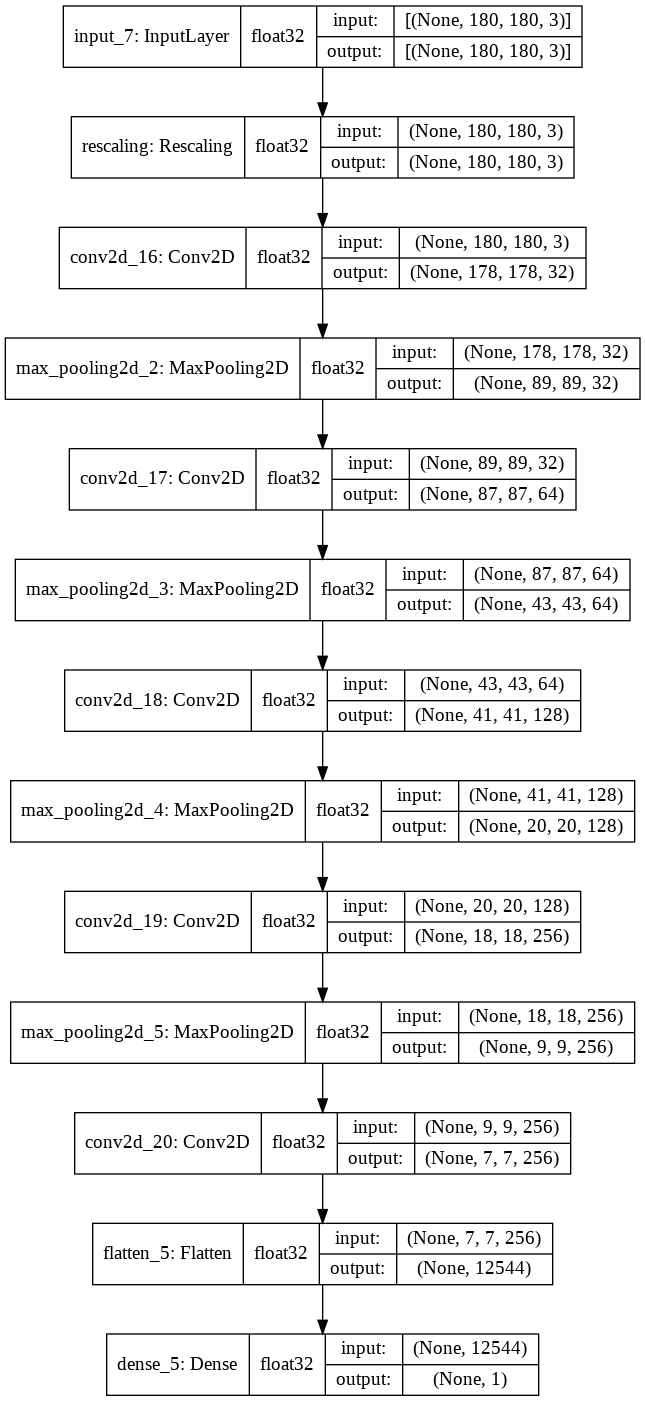

In [26]:
keras.utils.plot_model(model, show_dtype=True, show_layer_names=True, show_shapes=True)

**Configuring the model for training**

In [27]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

### Data preprocessing

As you know by now, data should be formatted into appropriately preprocessed floating-point tensors before being fed into the model. Currently, the data sits on a drive as JPEG files, so the steps for getting it into the model are roughly as follows:

- Read the picture files.
- Decode the JPEG content to RGB grids of pixels.
- Convert these into floating-point tensors.
- Resize them to a shared size (we’ll use $180 \times 180$).
- Pack them into batches (we’ll use batches of $32$ images).

It may seem a bit daunting, but fortunately Keras has utilities to take care of these steps automatically. In particular, Keras features the utility function `image_dataset_from_directory`, which lets you quickly set up a data pipeline that can automatically turn image files on disk into batches of preprocessed tensors. This is what you’ll use here.

Calling `image_dataset_from_directory(directory)` will first list the subdirectories of directory and assume each one contains images from one of your class. It will then index the image files in each subdirectory. Finally, it will create and return a `tf.data.Dataset` object configured to read these files, shuffle them, decode them to tensors, resize them to a shared size, and pack them into batches.

#### Using `image_dataset_from_directory` to read images from directories

In [28]:
from pathlib import Path
from tensorflow.keras.utils import image_dataset_from_directory

base_dir = Path("dogs_vs_cats_small")

train_dataset = image_dataset_from_directory(
    base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


#### Instantiating a Dataset from a NumPy array

TensorFlow makes available the `tf.data API` to create efficient input pipelines for machine learning models. Its core class is `tf.data.Datase`.

A `Dataset` object is an **iterator**: you can use it in a `for` loop. It will typically return batches of input data and labels. You can pass a `Dataset` object directly to the `fit()` method of a Keras model.

The `Dataset` class handles many key features that would otherwise be cumbersome to implement yourself, a in particular asynchronous data prefetching (preprocessing the next batch of data while the previous one is being handled by the model, which keeps execution flowing without interruptions).

The `Dataset` class also exposes a functional-style API for modifying datasets. Here’s a quick example: let’s create a `Dataset` instance from a NumPy array of random numbers. We’ll consider 1000 samples, where each sample is a vector of size 16.


In [29]:
import numpy as np
import tensorflow as tf

random_numbers = np.random.normal(size=(1000, 16))
dataset = tf.data.Dataset.from_tensor_slices(random_numbers)

#### Iterating on a dataset

At first, our dataset just yield single samples:

In [30]:
for i, element in enumerate(dataset):
    print(element.shape)
    if i >= 2:
        break

(16,)
(16,)
(16,)


#### Batching a dataset

You can use the `.batch()` method to batch the data:

In [31]:
batched_dataset = dataset.batch(32)
for i, element in enumerate(batched_dataset):
    print(element.shape)
    if i >= 2:
        break

(32, 16)
(32, 16)
(32, 16)


#### Applying a transformation to Dataset elements using `map()`

More broadly, you have access to a range of useful dataset methods, such as:

- `.shuffle(buffer_size)` will shuffle elements within a buffer.
- `.prefetch(buffer_size)` will prefetch a buffer of elements in GPU memory to achieve better device utilization.
- `.map(callable)` will apply an arbitrary **transformation** to each element of the dataset (the function callable, expected to take as input a single element yielded by the dataset).

The method `.map()` in particular is one that you will use often. Here’s an example: let’s use it to reshape the elements in our toy dataset from shape (16,) to shape (4, 4):


In [32]:
reshaped_dataset = dataset.map(lambda x: tf.reshape(x, (4, 4)))
for i, element in enumerate(reshaped_dataset):
    print(element.shape)
    if i >= 2:
        break

(4, 4)
(4, 4)
(4, 4)


#### Displaying the shapes of the data and labels yielded by the Dataset

Let’s look at the output of one of these `Dataset` objects: it yields batches of 180 × 180 RGB images (shape (32, 180, 180, 3)) and integer labels (shape (32,)). There are 32 samples in each batch (the batch size).

In [ ]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


#### Fitting the model using a Dataset

Let’s fit the model on our dataset. We use the `validation_data` argument in `fit()` to monitor validation metrics on a separate Dataset object.

Note that we also use a `ModelCheckpoint` callback to save the model after each epoch. We configure it with the path where to save the file, as well as the arguments `save_best_only=True` and `monitor="val_loss"`: they tell the callback to only save a new file (overwriting any previous one) when the current value of the val_loss metric is lower than at any previous time during training. This guarantees that your saved file will always contain the state of the model corresponding to its best-performing training epoch, in terms of its performance on the validation data. As a result, we won’t have to retrain a new model for a lower number of epochs if we start overfitting: we can just reload our saved file.

In [33]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="models/dogs-vs-cats/convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]

history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks,
    use_multiprocessing=True
)

Epoch 1/30
63/63 [==============================] - 7s 81ms/step - loss: 0.7513 - accuracy: 0.5070 - val_loss: 0.6888 - val_accuracy: 0.5670
Epoch 2/30
63/63 [==============================] - 5s 67ms/step - loss: 0.6911 - accuracy: 0.5615 - val_loss: 0.6564 - val_accuracy: 0.5840
Epoch 3/30
63/63 [==============================] - 4s 66ms/step - loss: 0.6625 - accuracy: 0.6225 - val_loss: 0.6537 - val_accuracy: 0.5970
Epoch 4/30
63/63 [==============================] - 4s 66ms/step - loss: 0.5993 - accuracy: 0.6740 - val_loss: 0.6496 - val_accuracy: 0.6010
Epoch 5/30
63/63 [==============================] - 4s 66ms/step - loss: 0.5696 - accuracy: 0.7120 - val_loss: 0.6001 - val_accuracy: 0.6730
Epoch 6/30
63/63 [==============================] - 4s 67ms/step - loss: 0.5419 - accuracy: 0.7260 - val_loss: 0.7115 - val_accuracy: 0.6540
Epoch 7/30
63/63 [==============================] - 4s 67ms/step - loss: 0.5233 - accuracy: 0.7355 - val_loss: 0.5712 - val_accuracy: 0.7080
Epoch 8/30
63

#### Displaying curves of loss and accuracy during training

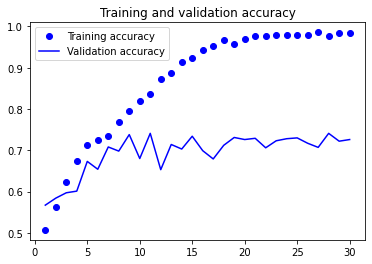

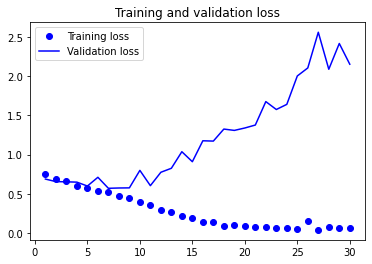

In [34]:
import matplotlib.pyplot as plt

accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()

plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

plt.show()

These plots are characteristic of overfitting. The training accuracy increases linearly over time, until it reaches nearly 100%, whereas the validation accuracy peaks at 75%. The validation loss reaches its minimum after only ten epochs and then stalls, whereas the training loss keeps decreasing linearly as training proceeds.

![](https://drek4537l1klr.cloudfront.net/chollet2/v-7/Figures/training-and-validation.png)

#### Evaluating the model on the test set

In [35]:
test_model = keras.models.load_model("models/dogs-vs-cats/convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 3s 37ms/step - loss: 0.5794 - accuracy: 0.7060
Test accuracy: 0.706


We get a test accuracy of 69.5% (due to the randomness of neural network initializations, you may get numbers within one percentage point of that).

Because you have relatively few training samples (2,000), **overfitting will be your number-one concern**. You already know about a number of techniques that can help mitigate overfitting, such as dropout and weight decay (L2 regularization). We’re now going to work with a new one, specific to computer vision and used almost universally when processing images with deep-learning models: **data augmentation**.


### Using data augmentation

**Overfitting is caused by having too few samples to learn from**, rendering you unable to train a model that can generalize to new data. Given infinite data, your model would be exposed to every possible aspect of the data distribution at hand: you would never overfit. 

Data augmentation takes the approach of generating more training data from existing training samples, by **augmenting** the samples via a number of **random transformations that yield believable-looking images**. The goal is that at training time, your model will never see the exact same picture twice. This helps expose the model to more aspects of the data and generalize better.

#### Define a data augmentation stage to add to an image model

In Keras, this can be done by adding a number of **data augmentation layers** at the start of your model. Let’s get started with an example: here’s a `Sequential` model that chains several random image transformations. In our model, we’d include it right before the ``Rescaling`` layer.

In [36]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

These are just a few of the layers available (for more, see the Keras documentation). Let’s quickly go over this code:

- `RandomFlip("horizontal")` will apply horizontal flipping to a random 50% of the images that go through it.
- `RandomRotation(0.1)` will rotation the input images by a random value in the range $[-10\%, +10\%]$ (these are fractions of a full circle—in degrees the range would be $[-36 degrees, +36 degrees]$).
- `RandomZoom(0.2)` will zoom in or out of the image by a random factor in the range $[-20\%, +20\%]$.

#### Displaying some randomly augmented training images

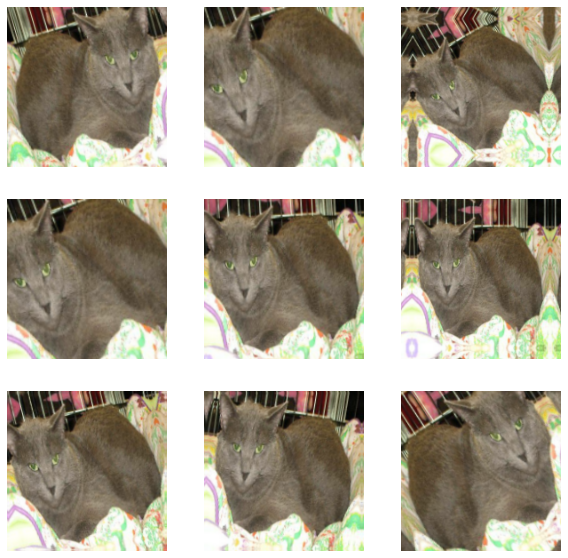

In [41]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

#### Defining a new convnet that includes image augmentation and dropout

If you train a new model using this **data-augmentation** configuration, the model will never see the same input twice. But the inputs it sees are still **heavily intercorrelated**, because they come from a small number of original images—you can’t produce new information, you can only remix existing information. As such, this may not be enough to completely get rid of overfitting. To further fight overfitting, you’ll also add a `Dropout` layer to your model, right before the densely connected classifier.

In [42]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)  # New! Fight overfitting with more input data 
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)  # New! Fight overfitting by avoid single neurons to dominate
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

#### Training the regularized convnet

Let’s train the model using data augmentation and dropout. Because we expect overfitting to occur much later during training, we will train for 3x as many epochs—one hundred.

In [43]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="models/dogs-vs-cats/convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/100
63/63 [==============================] - 6s 68ms/step - loss: 0.7442 - accuracy: 0.4915 - val_loss: 0.6935 - val_accuracy: 0.5000
Epoch 2/100
63/63 [==============================] - 4s 66ms/step - loss: 0.7095 - accuracy: 0.5135 - val_loss: 0.7065 - val_accuracy: 0.5060
Epoch 3/100
63/63 [==============================] - 5s 70ms/step - loss: 0.7166 - accuracy: 0.5835 - val_loss: 0.7114 - val_accuracy: 0.5240
Epoch 4/100
63/63 [==============================] - 4s 68ms/step - loss: 0.6766 - accuracy: 0.6035 - val_loss: 0.6688 - val_accuracy: 0.6180
Epoch 5/100
63/63 [==============================] - 5s 69ms/step - loss: 0.6624 - accuracy: 0.6340 - val_loss: 0.6595 - val_accuracy: 0.5970
Epoch 6/100
63/63 [==============================] - 5s 69ms/step - loss: 0.6610 - accuracy: 0.6330 - val_loss: 0.6250 - val_accuracy: 0.6460
Epoch 7/100
63/63 [==============================] - 4s 67ms/step - loss: 0.6357 - accuracy: 0.6535 - val_loss: 0.6118 - val_accuracy: 0.6530
Epoch 

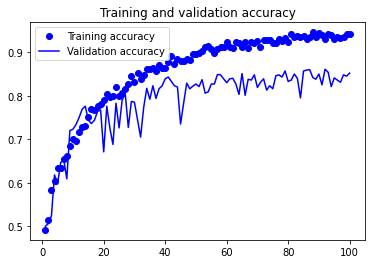

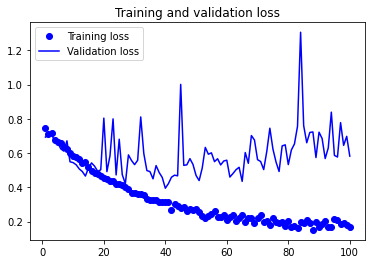

In [44]:
import matplotlib.pyplot as plt

accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()

plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

plt.show()

Let’s plot the results again: see figure 8.11. Thanks to data augmentation and dropout, we start overfitting much later, around epochs 60-70 (compared to epoch 10 for the original model). The validation accuracy ends up consistently in the 80-85% range—a big improvement over our first try.

![](https://drek4537l1klr.cloudfront.net/chollet2/v-7/Figures/training-and-validation_da.png)

#### Evaluating the model on the test set

In [45]:
test_model = keras.models.load_model(
    "models/dogs-vs-cats/convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 3s 39ms/step - loss: 0.4534 - accuracy: 0.8385
Test accuracy: 0.839


We get a test accuracy of 83.5%. It’s starting to look good! If you’re using Colab, make sure to download the saved file (convnet_from_scratch_with_augmentation.keras), as we will use it for some experiments in the next chapter.

By further tuning the model’s configuration (such as the number of filters per convolution layer, or the number of layers in the model), you may be able to get an even better accuracy, likely up to 90%. **But it would prove difficult to go any higher just by training your own convnet from scratch, because you have so little data to work with**. As a next step to improve your accuracy on this problem, you’ll have to use a pretrained model, which is the focus of the next two sections.

## Leveraging a pretrained model

A common and highly effective approach to deep learning on small image datasets is to use a **pretrained model**. A pretrained model is a model that was previously trained on a large dataset, typically on a large-scale image-classification task. If this original dataset is large enough and general enough, then the spatial hierarchy of features learned by the pretrained model can effectively act as a generic model of the visual world, and hence its features can prove useful for many different computer-vision problems, even though these new problems may involve completely different classes than those of the original task. For instance, you might train a model on ImageNet (where classes are mostly animals and everyday objects) and then **repurpose this trained model** for something as remote as identifying furniture items in images. Such portability of learned features across different problems is a key advantage of deep learning compared to many older, shallow-learning approaches, and it makes deep learning very effective for small-data problems.

In this case, let’s consider a large convnet trained on the ImageNet dataset (1.4 million labeled images and 1,000 different classes). ImageNet contains many animal classes, including different species of cats and dogs, and you can thus expect it to perform well on the dogs-versus-cats classification problem.

You’ll use the **VGG16** architecture, developed by Karen Simonyan and Andrew Zisserman in 2014.[11] Although it’s an older model, far from the current state of the art and somewhat heavier than many other recent models, I chose it because its architecture is similar to what you’re already familiar with and is easy to understand without introducing any new concepts. This may be your first encounter with one of these cutesy model names—VGG, ResNet, Inception, Xception, and so on; you’ll get used to them, because they will come up frequently if you keep doing deep learning for computer vision.

There are two ways to use a pretrained model: feature extraction and fine-tuning. We’ll cover both of them. Let’s start with feature extraction.

### Feature extraction with a pretrained model

Feature extraction consists of using the **representations learned by a previously-trained model** to extract interesting features from new samples. These features are then run through a new classifier, which is trained from scratch.

As you saw previously, convnets used for image classification comprise two parts: they start with a series of pooling and convolution layers, and they end with a densely connected classifier. The first part is called the **convolutional base** of the model. In the case of convnets, feature extraction consists of taking the convolutional base of a previously-trained network, running the new data through it, and training a new classifier on top of the output (see figure).

![](https://drek4537l1klr.cloudfront.net/chollet2/v-7/Figures/swapping_fc_classifier.png)

The feature maps of a convnet are **presence maps of generic concepts over a picture**, which is likely to be useful regardless of the computer-vision problem at hand. But the representations learned by the classifier will necessarily be specific to the set of classes on which the model was trained—they will only contain information about the **presence probability of this or that class in the entire picture**. Additionally, representations found in densely connected layers no longer contain any information about where objects are located in the input image: **these layers get rid of the notion of space**, whereas the object location is still described by convolutional feature maps. **For problems where object location matters, densely connected features are largely useless**.

Note that the **level of generality** (and therefore reusability) of the representations extracted by specific convolution layers depends on the depth of the layer in the model. Layers that come earlier in the model **extract local, highly generic feature maps** (such as visual edges, colors, and textures), whereas layers that are higher up extract **more-abstract concepts** (such as "cat ear" or "dog eye"). So if your new dataset differs a lot from the dataset on which the original model was trained, you may be better off using only the first few layers of the model to do feature extraction, rather than using the entire convolutional base.

**Instantiating the VGG16 convolutional base**

Let’s put this in practice by using the convolutional base of the **VGG16** network, trained on **ImageNet**, to extract interesting features from cat and dog images, and then train a dogs-versus-cats classifier on top of these features.

The **VGG16** model, among others, comes prepackaged with Keras. You can import it from the `keras.applications` module. Many other image-classification models (all pretrained on the ImageNet dataset) are available as part of `keras.applications`:

- Xception
- ResNet
- MobileNet
- EfficientNet
- DenseNet

Let’s instantiate the VGG16 model.

In [46]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3)
)

58900480/58889256 [==============================] - 0s 0us/step


You pass two arguments to the constructor:

- `weights` specifies the weight checkpoint from which to initialize the model.
- `include_top` refers to including (or not) the densely connected classifier on top of the network. By default, this densely connected classifier corresponds to the **1,000 classes from ImageNet**. Because you intend to use your own densely connected classifier (with only two classes: cat and dog), you don’t need to include it.
- `input_shape` is the shape of the image tensors that you’ll feed to the network. This argument is purely optional: if you don’t pass it, the network will be able to process inputs of any size. Here, we pass so that we can visualize how the size of the feature maps shrink with each new convolution and pooling layer, in the summary below.

In [47]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 180, 180, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 180, 180, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 90, 90, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 90, 90, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 90, 90, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 45, 45, 128)       0     

The final feature map has shape (5, 5, 512). That’s the feature map on top of which you’ll stick a densely-connected classifier.

At this point, there are two ways you could proceed:

- Running the convolutional base over your dataset, recording its output to a NumPy array on disk, and then using this data as **input to a standalone, densely-connected classifier** similar to those you saw in part 1 of this book. This solution is fast and cheap to run, because it only requires running the convolutional base once for every input image, and the convolutional base is by far the most expensive part of the pipeline. But for the same reason, this technique won’t allow you to use data augmentation.
- **Extending the model you have (conv_base) by adding Dense layers on top, and running the whole thing end to end on the input data**. This will allow you to use data augmentation, because every input image goes through the convolutional base every time it’s seen by the model. But for the same reason, this technique is far more expensive than the first.

#### Fast feature extraction without data augmentation

**Extracting the VGG16 features and corresponding labels**

You’ll start by extracting features as NumPy arrays, by calling the ``predict()`` method of the ``conv_base`` model on our training, validation, and testing datasets.

Let’s iterate over our datasets to extract the VGG16 features:


Importantly, `predict()` only expects images, not labels, but our current dataset yield batches that contain both images and their labels. Moreover, the **VGG16 model** expects inputs that are preprocessed with the function `keras.applications.vgg16.preprocess_input`, which scales pixel values to an appropriate range.

In [48]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

In [55]:
train_dataset.take(1).get_single_element()[0].shape

TensorShape([32, 180, 180, 3])

The extracted features are currently of shape ``(samples, 5, 5, 512)``:

In [49]:
train_features.shape

(2000, 5, 5, 512)

**Defining and training the densely connected classifier**

At this point, you can define your densely connected classifier (note the use of dropout for regularization) and train it on the data and labels that you just recorded.

Training is very fast, because you only have to deal with two Dense layers—an epoch takes less than one second even on CPU.

In [56]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)  # necessary because we have a convnet that outputs a 3D tensor
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)  # Dropout to fight regularization
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="feature_extraction.keras",
      save_best_only=True,
      monitor="val_loss")
]
history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/20
63/63 [==============================] - 1s 9ms/step - loss: 18.8026 - accuracy: 0.9265 - val_loss: 3.1388 - val_accuracy: 0.9740
Epoch 2/20
63/63 [==============================] - 0s 6ms/step - loss: 4.5401 - accuracy: 0.9740 - val_loss: 2.9344 - val_accuracy: 0.9750
Epoch 3/20
63/63 [==============================] - 0s 5ms/step - loss: 2.1526 - accuracy: 0.9830 - val_loss: 3.9217 - val_accuracy: 0.9730
Epoch 4/20
63/63 [==============================] - 0s 5ms/step - loss: 1.3710 - accuracy: 0.9850 - val_loss: 8.0473 - val_accuracy: 0.9600
Epoch 5/20
63/63 [==============================] - 0s 6ms/step - loss: 1.2281 - accuracy: 0.9930 - val_loss: 4.5825 - val_accuracy: 0.9710
Epoch 6/20
63/63 [==============================] - 0s 5ms/step - loss: 0.7114 - accuracy: 0.9955 - val_loss: 6.9336 - val_accuracy: 0.9650
Epoch 7/20
63/63 [==============================] - 0s 5ms/step - loss: 0.8505 - accuracy: 0.9940 - val_loss: 4.0629 - val_accuracy: 0.9740
Epoch 8/20
63/63 [=

In [57]:
model.evaluate(test_features, test_labels)

63/63 [==============================] - 0s 2ms/step - loss: 8.7259 - accuracy: 0.9705


[8.72590160369873, 0.9704999923706055]

**Plotting the results**

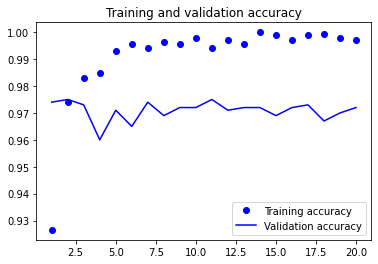

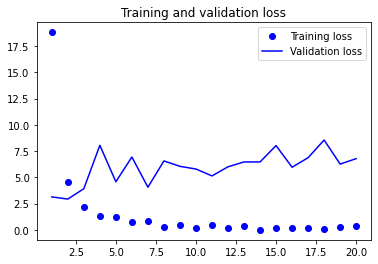

In [58]:
import matplotlib.pyplot as plt

acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()

plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

You reach a validation accuracy of about 97%—much better than you achieved in the previous section with the small model trained from scratch. This is a bit of an unfair comparison, however, because ImageNet contains many dogs and cats instances, which means that our pretrained model already has very the exact knowledge required for the task at hand. This won’t always be the case when you use pretrained features.

However, the plots also indicate that you’re overfitting **almost from the start**—despite using dropout with a fairly large rate. That’s because this technique doesn’t use data augmentation, which is **essential for preventing overfitting with small image datasets**.

![](https://drek4537l1klr.cloudfront.net/chollet2/v-7/Figures/training-and-validation_fe.png)



#### Feature extraction together with data augmentation

Now, let’s review the second technique I mentioned for doing feature extraction, which is much slower and more expensive, but which allows you to use data augmentation during training: creating a model that chains the conv_base with a new dense classifier, and training it end to end on the inputs.

In order to do this, we will first **freeze** the convolutional base. Freezing a layer or set of layers means **preventing their weights from being updated during training**. Here, if you don’t do this, then the representations that were previously learned by the convolutional base will be modified during training. Because the Dense layers on top are randomly initialized, very large weight updates would be propagated through the network, effectively destroying the representations previously learned.

In Keras, you freeze a layer or model by setting its `trainable` attribute to False:

**Instantiating and freeze the VGG16 convolutional base**

In [59]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False  # avoid weight updates

**Printing the list of trainable weights before and after freezing**

Trainable weights are the matrices, so we have 26 trainable matrices, that is not the number of trainable parameters!

In [60]:
conv_base.trainable = True
print("This is the number of trainable"
      "before freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainablebefore freezing the conv base: 26


In [61]:
conv_base.trainable = False
print("This is the number of trainable"
      "after freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainableafter freezing the conv base: 0


**Adding data augmentation and a densely-connected classifier to the frozen convolutional base**

Now, we can just create a new model that chains together:

- A data augmentation stage
- Our frozen convolutional base
- A dense classifier

In [62]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

With this setup, only the weights from the two Dense layers that you added will be trained. That’s a total of four weight tensors: two per layer (the main weight matrix and the bias vector).

In [63]:
len(model.trainable_weights)

4

**warning**: This technique is expensive enough that you should only attempt it if you have access to a GPU (such as the free GPU available in Colab)—it’s intractable on CPU. If you can’t run your code on GPU, then the previous technique is the way to go.

In [64]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="models/dogs-vs-cats/feature_extraction_with_data_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=20,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/20
63/63 [==============================] - 10s 143ms/step - loss: 16.8543 - accuracy: 0.8995 - val_loss: 3.3906 - val_accuracy: 0.9730
Epoch 2/20
63/63 [==============================] - 9s 142ms/step - loss: 7.0104 - accuracy: 0.9435 - val_loss: 5.9672 - val_accuracy: 0.9660
Epoch 3/20
63/63 [==============================] - 9s 143ms/step - loss: 5.5047 - accuracy: 0.9550 - val_loss: 4.3691 - val_accuracy: 0.9720
Epoch 4/20
63/63 [==============================] - 9s 144ms/step - loss: 5.1797 - accuracy: 0.9580 - val_loss: 7.3001 - val_accuracy: 0.9560
Epoch 5/20
63/63 [==============================] - 9s 146ms/step - loss: 4.1139 - accuracy: 0.9650 - val_loss: 3.0260 - val_accuracy: 0.9780
Epoch 6/20
63/63 [==============================] - 9s 147ms/step - loss: 3.1633 - accuracy: 0.9715 - val_loss: 3.7606 - val_accuracy: 0.9760
Epoch 7/20
63/63 [==============================] - 10s 148ms/step - loss: 3.3432 - accuracy: 0.9730 - val_loss: 2.4746 - val_accuracy: 0.9790
Epo

**Evaluating the model on the test set**

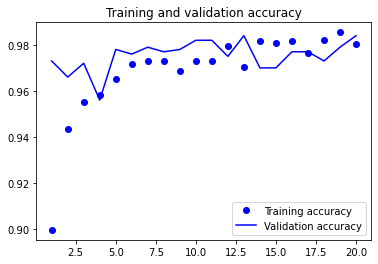

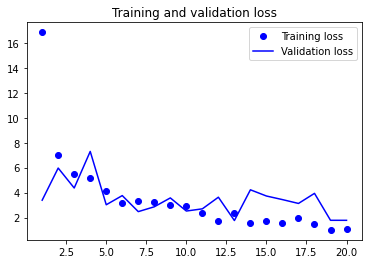

In [65]:
import matplotlib.pyplot as plt

acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()

plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

![](https://drek4537l1klr.cloudfront.net/chollet2/v-7/Figures/training-and-validation_da_fe.png)

In [ ]:
test_model = keras.models.load_model(
    "models/dogs-vs-cats/feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 255s 4s/step - loss: 2.5994 - accuracy: 0.9740
Test accuracy: 0.974


We get a test accuracy of 97.5%. This is only a modest improvement compared to the previous test accuracy, which is a bit disappointing given the strong results on the validation data. A model’s accuracy always depends on the set of samples you evaluate it on! Some sample sets may be more difficult than others, and strong results on one set won’t necessarily fully translate to all other sets.

### Fine-tuning a pretrained model

Another widely used technique for model reuse, complementary to feature extraction, is **fine-tuning** (see figure). Fine-tuning consists of **unfreezing a few of the top layers** of a frozen model base used for feature extraction, and jointly training both the newly added part of the model (in this case, the fully connected classifier) and these top layers. This is called fine-tuning because it slightly adjusts the more abstract representations of the model being reused, in order to make them more relevant for the problem at hand.

![](https://drek4537l1klr.cloudfront.net/chollet2/v-7/Figures/vgg16_fine_tuning.png)

I stated earlier that it’s necessary to freeze the convolution base of VGG16 in order to be able to train a randomly initialized classifier on top. For the same reason, **it’s only possible to fine-tune the top layers of the convolutional base once the classifier on top has already been trained**. If the classifier isn’t already trained, then the error signal propagating through the network during training will be too large, and the representations previously learned by the layers being fine-tuned will be destroyed. Thus the steps for fine-tuning a network are as follow:

1. Add your custom network on top of an already-trained base network.
2. Freeze the base network.
3. Train the part you added.
4. Unfreeze some layers in the base network. (Note that you should not unfreeze "batch normalization" layers, which is not relevant here since there are no such layers in VGG16. Batch normalization and its impact on fine-tuning is explained in the next chapter.)
5. Jointly train both these layers and the part you added.

We already completed the first three steps when doing feature extraction. Let’s proceed with step 4: we'll unfreeze our conv_base and then freeze individual layers inside it.

In [66]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

**Freezing all layers until the 4th from the last**

You’ll fine-tune the last three convolutional layers, which means all layers up to ``block4_pool`` should be frozen, and the layers ``block5_conv1``, ``block5_conv2``, and ``block5_conv3`` should be trainable.

Why not fine-tune more layers? Why not fine-tune the entire convolutional base? You could. But you need to consider the following:

- Earlier layers in the convolutional base encode **more-generic, reusable features**, whereas layers higher up encode more-specialized features. **It’s more useful to fine-tune the more specialized features**, because these are the ones that need to be repurposed on your new problem. There would be fast-decreasing returns in fine-tuning lower layers.
- The more parameters you’re training, the more you’re at risk of overfitting. The convolutional base has **15 million parameters**, so it would be risky to attempt to train it on your small dataset.

Thus, in this situation, it’s a good strategy to fine-tune only the top two or three layers in the convolutional base. Let’s set this up, starting from where you left off in the previous example.


In [67]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

**Fine-tuning the model**

Now you can begin fine-tuning the model. You’ll do this with the RMSprop optimizer, **using a very low learning rate**. The reason for using a low learning rate is that **you want to limit the magnitude of the modifications** you make to the representations of the three layers you’re fine-tuning. Updates that are too large may harm these representations.

In [68]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 12s 160ms/step - loss: 1.2150 - accuracy: 0.9805 - val_loss: 1.5036 - val_accuracy: 0.9840
Epoch 2/30
63/63 [==============================] - 10s 158ms/step - loss: 0.7390 - accuracy: 0.9860 - val_loss: 1.2178 - val_accuracy: 0.9850
Epoch 3/30
63/63 [==============================] - 10s 159ms/step - loss: 0.5658 - accuracy: 0.9825 - val_loss: 1.6373 - val_accuracy: 0.9750
Epoch 4/30
63/63 [==============================] - 10s 160ms/step - loss: 0.4661 - accuracy: 0.9895 - val_loss: 1.1873 - val_accuracy: 0.9840
Epoch 5/30
63/63 [==============================] - 10s 162ms/step - loss: 0.4075 - accuracy: 0.9880 - val_loss: 1.5656 - val_accuracy: 0.9810
Epoch 6/30
63/63 [==============================] - 11s 164ms/step - loss: 0.3325 - accuracy: 0.9910 - val_loss: 1.5573 - val_accuracy: 0.9820
Epoch 7/30
63/63 [==============================] - 11s 166ms/step - loss: 0.4350 - accuracy: 0.9890 - val_loss: 1.4108 - val_accuracy: 0.9840

You can now finally evaluate this model on the test data:

In [70]:
model = keras.models.load_model("fine_tuning.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 7s 101ms/step - loss: 1.5522 - accuracy: 0.9770
Test accuracy: 0.977


Here, you get a test accuracy of 98.5% (again, your own results may be within one percentage point). In the original Kaggle competition around this dataset, this would have been one of the top results. It’s not quite a fair comparison, however, since you used pretrained features that already contained prior knowledge about cats and dogs, which competitors couldn’t use at the time.

On the positive side, by leveraging modern deep-learning techniques, **you managed to reach this result using only a small fraction of the training data that was available for the competition (about 10%)**. There is a huge difference between being able to train on 20,000 samples compared to 2,000 samples!


## Chapter summary

- Convnets are the best type of machine-learning models for computer-vision tasks. **It’s possible to train one from scratch even on a very small dataset, with decent results**.
- Convnets work by learning a **hierarchy of modular patterns and concepts** to represent the visual world.
- On a small dataset, **overfitting will be the main issue**. **Data augmentation** is a powerful way to fight overfitting when you’re working with image data.
- It’s easy to **reuse an existing convnet** on a new dataset via **feature extraction**. This is a valuable technique for working with small image datasets.
- As a complement to feature extraction, you can use **fine-tuning**, which adapts to a new problem some of the representations previously learned by an existing model. This pushes performance a bit further.